In [3]:
import joblib
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, log_loss, confusion_matrix, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


from model import read_data, cal_score

In [4]:
DATA_ROOT = 'data/'
continuous_col = ['publand', 'robbery', 'urban_proj', 'monitor', 'idle', 'school', 'park', 'mrt', 'rob', ]
binary_col = ['DistanceType1_School', 'DistanceType1_Park',
                  'DistanceType1_MRT', 'DistanceType1_ROB', 
                  'DistanceType2_School', 'DistanceType2_Park', 
                  'DistanceType2_MRT', 'DistanceType2_ROB',
                  'MonitorType1', 'MonitorType2',]
mix_col = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 
               'Feature5', 'Feature6', 'Feature7', 'Feature8']
target_col = ['output']

## Decision tree

- 不需要 scaling

In [147]:
theft_type = 'home'
X_train, X_test, y_train, y_test = read_data(DATA_ROOT, theft_type)

In [148]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

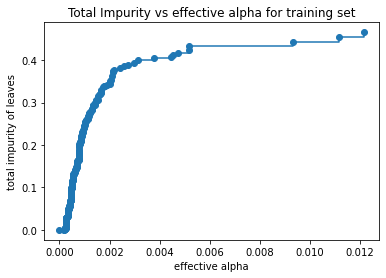

In [99]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [100]:
full_model = DecisionTreeClassifier(ccp_alpha=ccp_alphas[0])
full_model.fit(X_train, y_train)
simple_model = DecisionTreeClassifier(ccp_alpha=ccp_alphas[-1])
simple_model.fit(X_train, y_train)
print(f'Number of tree nodes: from {full_model.tree_.node_count} to {simple_model.tree_.node_count}')
print(f'Max depth of tree: from {full_model.tree_.max_depth} to {simple_model.tree_.max_depth}')

Number of tree nodes: from 1209 to 1
Max depth of tree: from 26 to 0


In [103]:
start_time = time.perf_counter()
parameter = {'ccp_alpha': ccp_alphas, }
SCORING = ['accuracy', 'f1', 'recall', 'roc_auc', 'precision'] 
cart_gs = GridSearchCV(DecisionTreeClassifier(), param_grid=parameter, cv=10, scoring=SCORING, 
                       refit='f1', return_train_score=True)
cart_result = cart_gs.fit(X_train, y_train)
search_time = time.perf_counter() - start_time

In [138]:
def cal_score(y_test, y_pred):

    # metric = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    return f1, accuracy, precision, recall, auc

In [1]:
def report(gs, result, scoring, x_train, y_train, search_time, model_name, theft_type, parameter=None):
    feature_names = pd.read_csv(os.path.join(DATA_ROOT, f'{theft_type}.csv')).drop(columns=['output']).columns
    def plot_metric(metric, ax, cart_result):
        markers, caps, bars = ax.errorbar(ccp_alphas, cart_result.cv_results_[f'mean_train_{metric}'], 
                                          cart_result.cv_results_[f'std_train_{metric}'], 
                                          label=f'training', ecolor='skyblue')
        [bar.set_alpha(1) for bar in bars]
        markers, caps, bars = ax.errorbar(ccp_alphas, cart_result.cv_results_[f'mean_test_{metric}'],
                                          cart_result.cv_results_[f'std_test_{metric}'], 
                                          label=f'validation', ecolor='orange', color='salmon')
        [bar.set_alpha(0.7) for bar in bars]
        best_id = cart_result.cv_results_[f'mean_test_{metric}'].argmax()
        best_metric = cart_result.cv_results_[f'mean_test_{metric}'][best_id]
        ax.scatter(ccp_alphas[best_id], best_metric, 
                    color='r', s=30, zorder=5)
        t = ax.text(ccp_alphas[best_id] + 0.001, best_metric - 0.05, 
                    f'alpha={ccp_alphas[best_id]: .4f}', fontsize=12)
        t.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
        ax.legend(loc='best')
        ax.set_title(f'{metric.capitalize()} v.s. alpha')
        ax.set_xlabel('alpha')
        ax.set_ylabel(metric)

    def plot_cv(result, scoring):
        fig, axes = plt.subplots(2, 3, figsize=(18, 8))
        axes = axes.ravel()
        for i in range(5):
            ax = axes[i]
            plot_metric(scoring[i], ax, result)

        plt.tight_layout()
        fig.delaxes(axes[5])
        plt.savefig(f'{model_name}_{theft_type}_cv.png', dpi=200)
        print('以 10 validation 的平均值繪製折線圖，折線圖上下的直條總共是兩單位標準差')
        
    def get_grids(parameter, result):
        grids = pd.DataFrame(columns=parameter['n_estimators'])
        grids['alpha'] = parameter['ccp_alpha']
        grids = grids.set_index('alpha')
        for i, key in enumerate(result.cv_results_['params']):
            grids.loc[key['ccp_alpha'], key['n_estimators']] = result.cv_results_['mean_test_f1'][i]
        fig, ax = plt.subplots(figsize=(15,20)) 
        sns.heatmap(result.cv_results_['mean_test_f1'].reshape(len(parameter['ccp_alpha']), len(parameter['n_estimators'])), 
                    cmap="RdBu_r", annot=True, fmt="0.3f", 
                    yticklabels=parameter['ccp_alpha'],
                    xticklabels=parameter['n_estimators'])
        plt.xlabel('n_estimators')
        plt.ylabel('ccp_alpha')
        plt.savefig(f'{model_name}_{theft_type}.png', dpi=200)

    def show_cv(gs, result, scoring, x_train, y_train, search_time):
        print(f'Best hyperparameter: {result.best_params_}')
        best_id = result.best_index_
        record = {'search_time': search_time}
        for metric in scoring:
            print(f'{metric} in validation: mean={result.cv_results_[f"mean_test_{metric}"][best_id]}, std={result.cv_results_[f"std_test_{metric}"][best_id]}')
            record[f'{metric}_mean'] = result.cv_results_[f"mean_test_{metric}"][best_id]
            record[f'{metric}_std'] = result.cv_results_[f"std_test_{metric}"][best_id]
        if 'n_estimators' in result.best_params_:
            rf = RandomForestClassifier(ccp_alpha=result.best_params_['ccp_alpha'], n_estimators=result.best_params_['n_estimators'])
            record['ccp_alpha'] = result.best_params_['ccp_alpha']
            record['n_estimators'] = result.best_params_['n_estimators']
            rf.fit(x_train, y_train)
            y_pred = rf.predict(X_test)
            metric = confusion_matrix(y_test, y_pred)
            print(f'Depth: mean={np.mean([estimator.tree_.max_depth for estimator in rf.estimators_])}, std={np.std([estimator.tree_.max_depth for estimator in rf.estimators_])}')
            print(f'Number of nodes: mean={np.mean([estimator.tree_.node_count for estimator in rf.estimators_])}, std={np.std([estimator.tree_.node_count for estimator in rf.estimators_])}')
            print(f'Number of leaves: mean={np.mean([estimator.tree_.n_leaves for estimator in rf.estimators_])}, std={np.std([estimator.tree_.n_leaves for estimator in rf.estimators_])}')
            record['depth_mean'] = np.mean([estimator.tree_.max_depth for estimator in rf.estimators_])
            record['depth_std'] = np.std([estimator.tree_.max_depth for estimator in rf.estimators_])
            record['node_mean'] = np.mean([estimator.tree_.node_count for estimator in rf.estimators_])        
            record['node_std'] = np.std([estimator.tree_.node_count for estimator in rf.estimators_])
            record['leaf_mean'] = np.mean([estimator.tree_.n_leaves for estimator in rf.estimators_])
            record['leaf_std'] = np.std([estimator.tree_.n_leaves for estimator in rf.estimators_])
            model = RandomForestClassifier(ccp_alpha=result.best_params_['ccp_alpha'], n_estimators=result.best_params_['n_estimators'])
            
            importances = rf.feature_importances_
            std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
            forest_importances = pd.Series(importances, index=feature_names)
            fig, ax = plt.subplots(figsize=(16, 6))
            plt.style.use('seaborn')
            forest_importances.plot.bar(yerr=std, ax=ax)
            ax.set_title("Feature importances using MDI")
            ax.set_ylabel("Mean decrease in impurity")
            plt.xticks(rotation=30, ha='right', fontsize=12)
            fig.tight_layout()
            plt.savefig(f'rf_{theft_type}_importance.png')
            
            result = permutation_importance(
                rf, X_test, y_test, n_repeats=10, random_state=42
            )  # , n_jobs=0
            forest_importances = pd.Series(result.importances_mean, index=feature_names)
            fig, ax = plt.subplots(figsize=(16, 6))
            plt.style.use('seaborn')
            forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
            ax.set_title("Feature importances using permutation on full model")
            ax.set_ylabel("Mean accuracy decrease")
            plt.xticks(rotation=30, ha='right', fontsize=12)
            fig.tight_layout()
            plt.savefig(f'rf_{theft_type}_permutation.png')
            
            model.fit(np.concatenate([X_train, X_test], axis=0), np.concatenate([y_train, y_test], axis=0))
            joblib.dump(model, f'{model_name}_{theft_type}.joblib')
                      
        else:
            cart = DecisionTreeClassifier(ccp_alpha=result.best_params_['ccp_alpha'])
            cart.fit(x_train, y_train)
            y_pred = cart.predict(X_test)
            metric = confusion_matrix(y_test, y_pred)
            print(f'Depth: {cart.tree_.max_depth}')
            print(f'Number of nodes: {cart.tree_.node_count}')
            print(f'Number of leaves: {cart.tree_.n_leaves}')
            record['depth'] = cart.tree_.max_depth
            record['node'] = cart.tree_.node_count
            record['leaf'] = cart.tree_.n_leaves
            model = DecisionTreeClassifier(ccp_alpha=result.best_params_['ccp_alpha'])
            model.fit(np.concatenate([X_train, X_test], axis=0), np.concatenate([y_train, y_test], axis=0))
            joblib.dump(model, f'{model_name}_{theft_type}.pkl')
        
        return metric, y_pred, record

    def show_confusion(metric, y_test, y_pred, record):
        fig, ax = plt.subplots(figsize=(7, 7))
        sns.heatmap(metric, square=True, annot=True, fmt='d', cbar=False, annot_kws={"size":15})
        plt.xlabel("predict value", fontsize=15)
        plt.ylabel("true value", fontsize=15)
        ax.xaxis.set_ticklabels(['safe', 'theft'], fontsize=13)
        ax.yaxis.set_ticklabels(['safe', 'theft'], fontsize=13)
        if len(model_name) > 4:
            name = ' '.join(map(str.capitalize, model_name.split('_')))
        else:
            name = model_name.upper()
        plt.title(f"{name} with {theft_type} data", fontsize=17)
        plt.savefig(f'{model_name}_{theft_type}_confusion.png', dpi=200)
        f1, accuracy, precision, recall, auc = cal_score(y_test, y_pred)
        record['f1'] = f1
        record['accuracy'] = accuracy
        record['precision'] = precision
        record['recall'] = recall
        record['roc_auc'] = auc
        print("report:\n",classification_report(y_test, y_pred)) 
        pd.DataFrame(record, index=range(1)).to_csv(f'{model_name}_{theft_type}.csv', index=False)
    
    if model_name == 'cart':
        plot_cv(result, SCORING)
    else:
        get_grids(parameter, result)
    metric, y_pred, record = show_cv(gs, result, SCORING, X_train, y_train, search_time)
    show_confusion(metric, y_test, y_pred, record)

以 10 validation 的平均值繪製折線圖，折線圖上下的直條總共是兩單位標準差
Best hyperparameter: {'ccp_alpha': 0.0002470101480002469}
accuracy in validation: mean=0.7966280053332568, std=0.02188910363869558
f1 in validation: mean=0.7977209007047897, std=0.02177810468110238
recall in validation: mean=0.8003356468312663, std=0.028494725514742646
roc_auc in validation: mean=0.7968210696424984, std=0.022096408562765676
precision in validation: mean=0.7957474105078371, std=0.025279614176374997
Depth: 26
Number of nodes: 1137
Number of leaves: 569
report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78       472
           1       0.77      0.80      0.79       463

    accuracy                           0.78       935
   macro avg       0.78      0.78      0.78       935
weighted avg       0.78      0.78      0.78       935



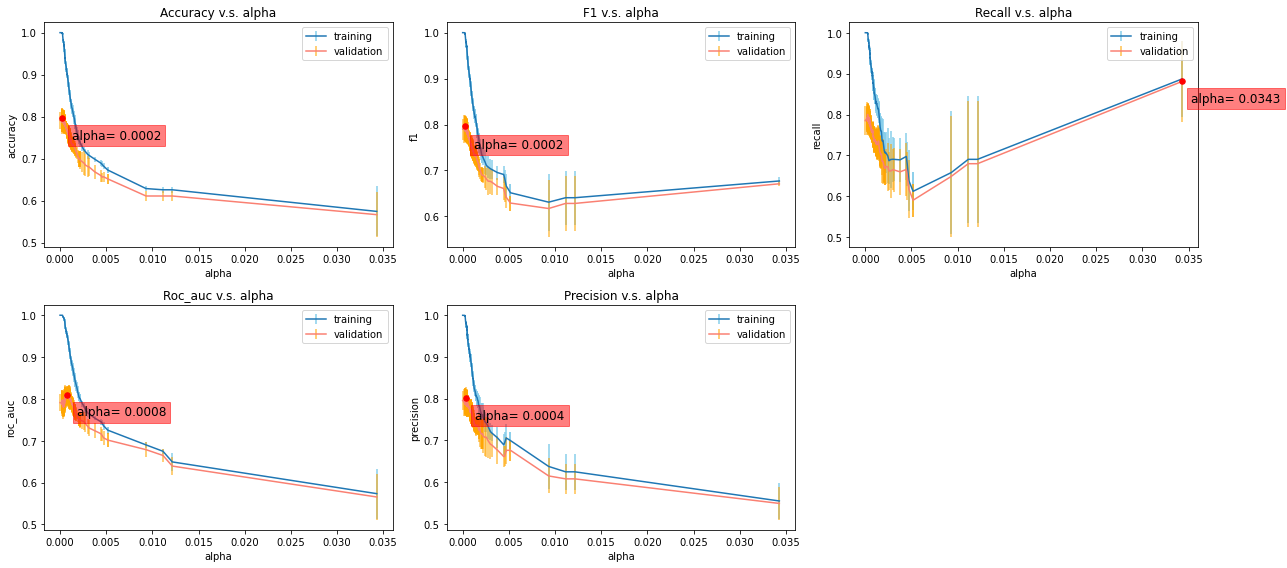

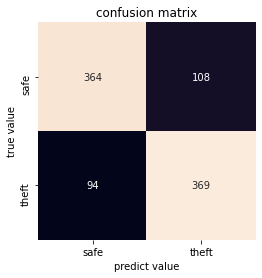

In [109]:
report(cart_gs, cart_result, SCORING, X_train, y_train, search_time, 'cart', theft_type)

## Random Forest

In [11]:
theft_type = 'bicycle'
X_train, X_test, y_train, y_test = read_data(DATA_ROOT, theft_type)

In [12]:
start_time = time.perf_counter()
parameter = {'n_estimators': np.geomspace(50, 1500, 6).round().astype('int'), 
             'ccp_alpha': np.concatenate([[0], np.geomspace(1e-5, 0.001, 10)])}
SCORING = ['accuracy', 'f1', 'recall', 'roc_auc', 'precision'] 
rf_gs = GridSearchCV(RandomForestClassifier(), param_grid=parameter, cv=10, scoring=SCORING, 
                        refit='f1', return_train_score=True)
rf_result = rf_gs.fit(X_train, y_train)
search_time = time.perf_counter() - start_time


Best hyperparameter: {'ccp_alpha': 7.742636826811278e-05, 'n_estimators': 195}
accuracy in validation: mean=0.8351579188828835, std=0.02030903065818744
f1 in validation: mean=0.8334653464949773, std=0.02118929826072959
recall in validation: mean=0.8237711912618046, std=0.027961916020291938
roc_auc in validation: mean=0.9128888587328637, std=0.01434552770695592
precision in validation: mean=0.8437794321581329, std=0.02057790481071315
Depth: mean=22.83076923076923, std=2.4299576704294448
Number of nodes: mean=1289.8410256410257, std=35.91200583440898
Number of leaves: mean=645.4205128205128, std=17.95600291720449
report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       472
           1       0.81      0.80      0.81       463

    accuracy                           0.81       935
   macro avg       0.81      0.81      0.81       935
weighted avg       0.81      0.81      0.81       935



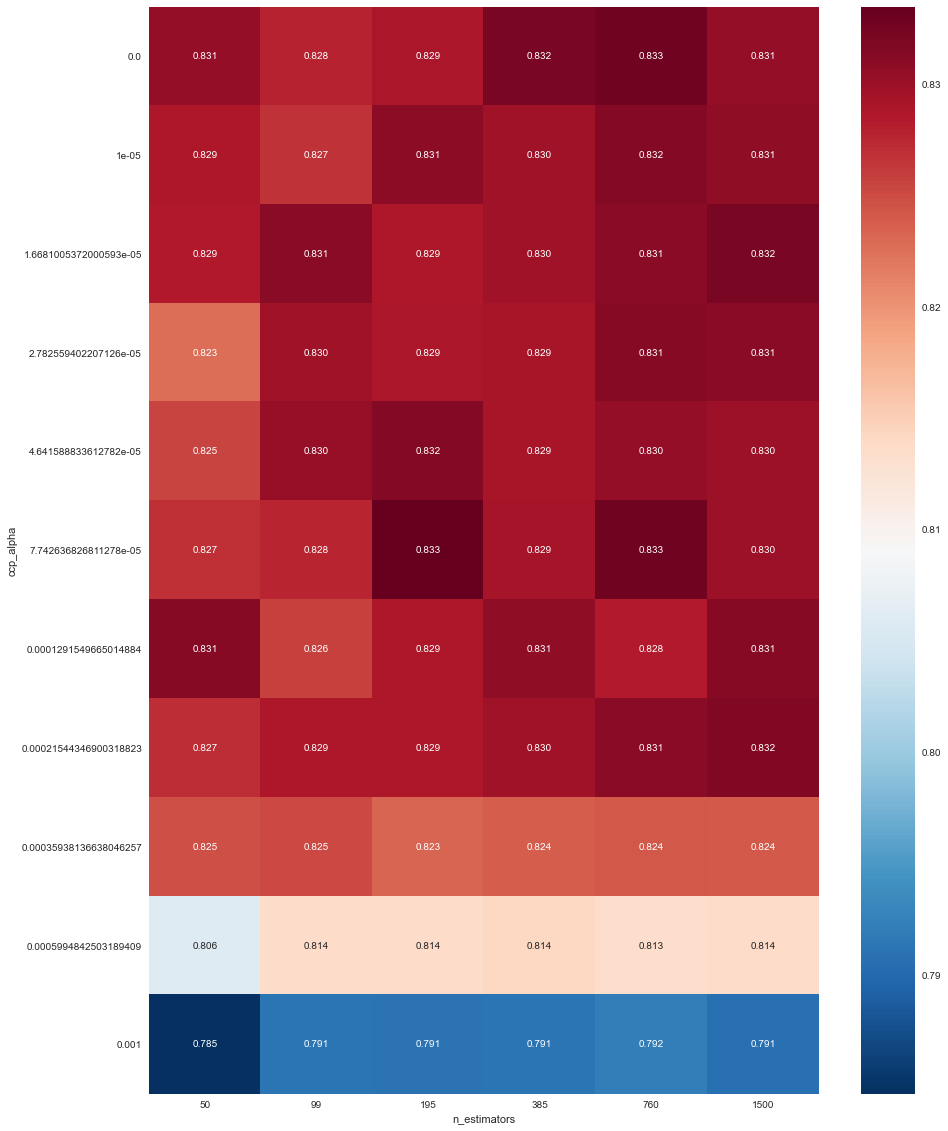

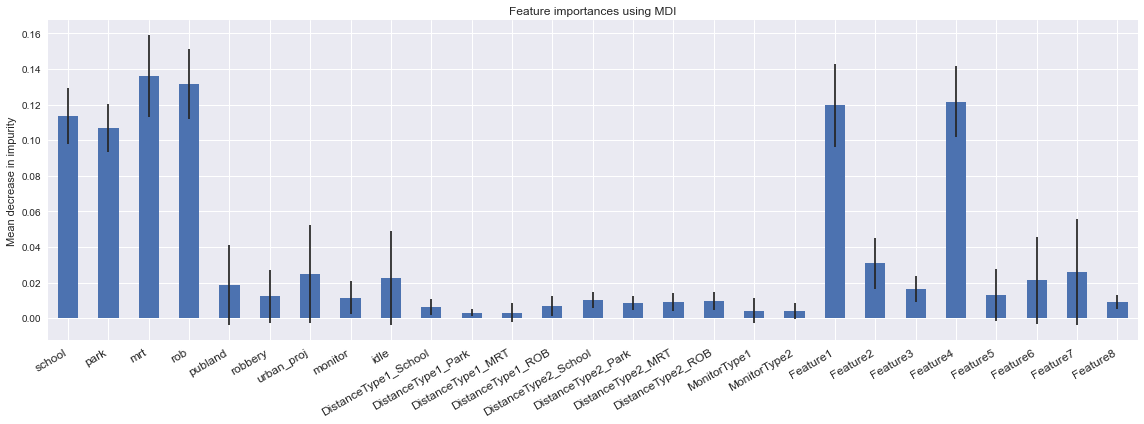

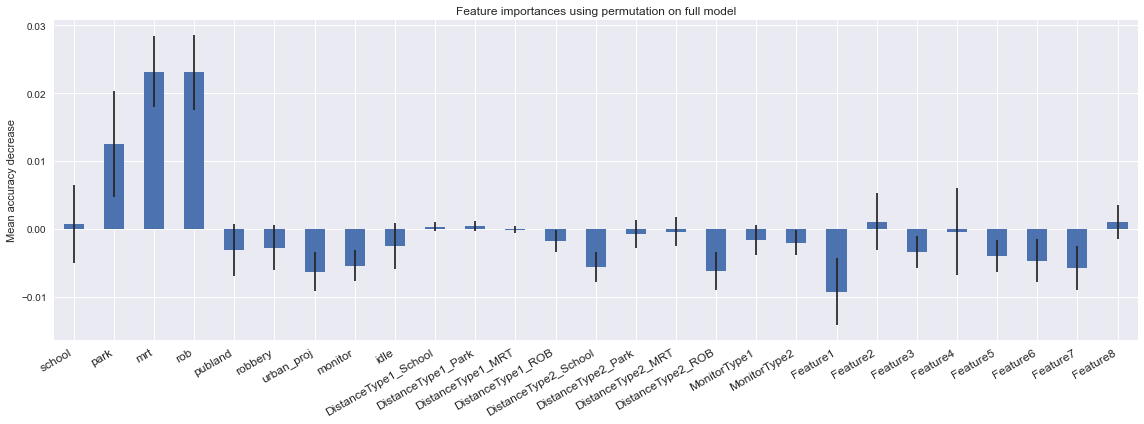

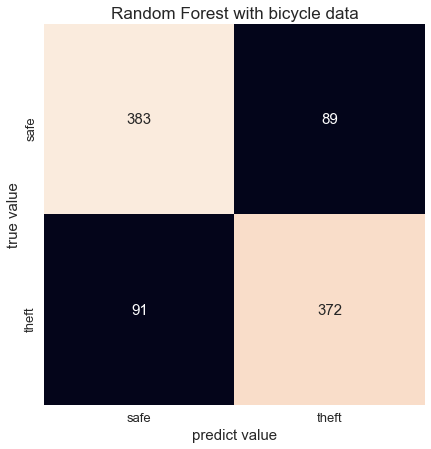

In [13]:
report(rf_gs, rf_result, SCORING, X_train, y_train, search_time, 'random_forest', theft_type, parameter)

## 產出書面需要的兩張圖

In [29]:
def plot_some(model_name, theft_type):
    
    def show_confusion(y_test, y_pred):
        metric = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots()
        sns.heatmap(metric, square=True, annot=True, cbar=False, fmt='d')
        plt.xlabel("predict value")
        plt.ylabel("true value")
        ax.xaxis.set_ticklabels(['safe', 'theft'])
        ax.yaxis.set_ticklabels(['safe', 'theft'])
        if len(model_name) > 4:
            name = ' '.join(map(str.capitalize, model_name.split('_')))
        else:
            name = model_name.upper()
        plt.title(f"{name} with {theft_type} data")
        plt.savefig(f'{model_name}/{model_name}_{theft_type}_confusion.png', dpi=200)
    
    model = joblib.load(os.path.join(model_name, f"{model_name}_{theft_type}.joblib"))
    
    # copy from read_data
    df = pd.read_csv('data/' + theft_type + '.csv')
    y_df = df[['output']]
    # drop 'address', 'district', 'output'
    x_df = df.drop(columns=['output'])
    feature_names = x_df.columns

    # 定義 X, y
    X = np.array(x_df)
    y = np.array(y_df).reshape(-1)
    # 洗牌
    X, y = shuffle(X, y, random_state=0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)
    
    if model_name == 'svm':
        # scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
#     y_pred = model.predict(X_test)
#     show_confusion(y_test, y_pred)
    
    if model_name == 'random_forest':
        
        importances = model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
        draw_df = pd.DataFrame(index=feature_names)
        draw_df['MDI'] = importances
        
        result = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=42
        )  # , n_jobs=0
        draw_df['permutation'] = result.importances_mean
        draw_df = draw_df.sort_values(by=['MDI'], ascending = False)
        
        plt.style.use('seaborn')
        fig, ax = plt.subplots(figsize=(18, 6))
        fig.patch.set_alpha(0)
        plt.title("Feature importances", fontsize=18)
        
        bar1 = draw_df.MDI.plot(kind='bar', yerr=std, ax=ax, color='salmon', label='MDI', position=1, width=0.35)
        ax.set_ylabel("Mean decrease in impurity", color='salmon', fontsize=15)
        ax.tick_params(axis='y', labelcolor='salmon')
        ax.legend(loc='upper left', fontsize=15)
        
        
        ax2 = ax.twinx()
        draw_df.permutation.plot(kind='bar', yerr=result.importances_std, ax=ax2, label='permutation', color='teal', position=0, width=0.35)
        ax2.set_ylabel("Mean accuracy decrease", color='teal', fontsize=15)
        ax2.tick_params(axis='y', labelcolor='teal')
        ax2.legend(fontsize=15)
        ax.set_xticklabels(draw_df.index, rotation=30, ha='right')

        plt.xlim(-1, len(feature_names))
        ax.set_ylim(0, 0.2)
        ax2.set_ylim(0, 0.08)

        plt.xticks(rotation=30, ha='right')
        fig.tight_layout()
        plt.savefig(f'rf_{theft_type}_feature.png', dpi=200, edgecolor='none')
        
    elif model_name == 'cart':
        
        importances = model.feature_importances_
        draw_df = pd.DataFrame(index=feature_names)
        draw_df['MDI'] = importances
        
        result = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=42
        )  # , n_jobs=0
        draw_df['permutation'] = result.importances_mean
        draw_df = draw_df.sort_values(by=['MDI'], ascending = False)
        
        plt.style.use('seaborn')
        fig, ax = plt.subplots(figsize=(18, 6))
        fig.patch.set_alpha(0)
        plt.title("Feature importances", fontsize=18)
        
        bar1 = draw_df.MDI.plot(kind='bar', ax=ax, color='salmon', label='MDI', position=1, width=0.35)
        ax.set_ylabel("Mean decrease in impurity", color='salmon', fontsize=15)
        ax.tick_params(axis='y', labelcolor='salmon')
        ax.legend(loc='upper left', fontsize=15)
        
        
        ax2 = ax.twinx()
        draw_df.permutation.plot(kind='bar', ax=ax2, label='permutation', color='teal', position=0, width=0.35)
        ax2.set_ylabel("Mean accuracy decrease", color='teal', fontsize=15)
        ax2.tick_params(axis='y', labelcolor='teal')
        ax2.legend(fontsize=15)
        ax.set_xticklabels(draw_df.index, rotation=30, ha='right')

        plt.xlim(-1, len(feature_names))
        ax.set_ylim(0, 0.2)
        ax2.set_ylim(0, 0.08)

        plt.xticks(rotation=30, ha='right')
        fig.tight_layout()
        plt.savefig(f'cart_{theft_type}_feature.png', dpi=200, edgecolor='none')
                            
    

In [17]:
plt.close()

In [33]:
plot_some('cart', 'home')

ValueError: Buffer dtype mismatch, expected 'SIZE_t' but got 'long long'

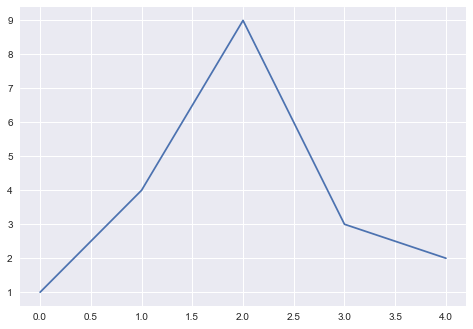

In [28]:
fig, ax = plt.subplots()
plt.plot([1, 4, 9, 3, 2])
fig.patch.set_alpha(0)
fig.savefig('foo.png')
plt.savefig('a.png', facecolor=None, transparant=True)